In [ ]:
pip install ta optuna tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=5d7d19dfa96eeccb0f4c5a3b704cd64a4deb50cfdd7730661f1c55de100e9977
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
import ta
import optuna
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# Load the data where the first row contains headers
correct_data = pd.read_csv('Calculated_Indicators.csv', header=0)

# Display the DataFrame
correct_data.head()

# Print all column names
print("Columns in the DataFrame:", correct_data.columns)

# Clean the column names by stripping extra spaces
correct_data.columns = correct_data.columns.str.strip()

# Ensure the Date column is correctly parsed and available
if 'Date' in correct_data.columns:
    # Convert the 'Date' column to datetime
    correct_data['Date'] = pd.to_datetime(correct_data['Date'], errors='coerce')

    # Print the first few rows to verify
    print("correct_data with Date column:")
    print(correct_data.head())

# Preprocess the data
correct_data['Date'] = pd.to_datetime(correct_data['Date'], format='%Y-%m-%d', errors='raise')
correct_data = correct_data.sort_values('Date')
correct_data.set_index('Date', inplace=True)

# Drop rows with NaN values resulting from technical indicators calculation
correct_data = correct_data.dropna()

# Define features for scaling
features = ['PX_LAST', 'OBV', 'Return', 'SMA_15', 'SMA_45', 'RSI', 'MACD', 'Bollinger_Mid', 'Bollinger_Upper']

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_correct_data = scaler.fit_transform(correct_data[features])

# Example dataset preparation function
def create_SVR_dataset_2D(scaled_correct_data):
    X, Y = [], []
    for i in range(len(scaled_correct_data) - 1):
        X.append(scaled_correct_data[i])
        Y.append(scaled_correct_data[i + 1, 0])  # Predicting 'PX_LAST' for next day
    return np.array(X), np.array(Y)

# Prepare dataset
X, Y = create_SVR_dataset_2D(scaled_correct_data)


# Define the split index for final testing
test_split_index = int(len(X) * 0.85)

# Split the data into train/validation and test sets
X_train_val, X_test = X[:test_split_index], X[test_split_index:]
Y_train_val, Y_test = Y[:test_split_index], Y[test_split_index:]

# Set up Time Series Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the objective function for Optuna with TimeSeriesSplit Cross-Validation
def objective(trial):
    # Define hyperparameters to tune
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    epsilon = trial.suggest_float('epsilon', 1e-3, 1e1, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3

    # Initialize SVR model with the current set of hyperparameters
    svr = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    val_losses = []

    # Time Series Cross-Validation loop
    for train_index, val_index in tscv.split(X_train_val):
        X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
        y_train_fold, y_val_fold = Y_train_val[train_index], Y_train_val[val_index]

        # Flatten each time step for SVR (only within each fold)
        X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], -1)
        X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], -1)

        svr.fit(X_train_fold, y_train_fold)
        val_loss = mean_squared_error(y_val_fold, svr.predict(X_val_fold))
        val_losses.append(val_loss)

    return np.mean(val_losses)

# Define the storage URL (this example uses SQLite for simplicity)
storage_url = 'sqlite:///unique_example.db'  # Changed to create a new study with a unique name

# Create a study with a unique name to avoid conflicts
study = optuna.create_study(direction='minimize', storage=storage_url, study_name='unique_svr_study', load_if_exists=True)

# Run the Optuna optimization with a progress bar
n_trials = 100  # Set the number of trials
timeout_per_trial = 600

with tqdm(total=n_trials) as pbar:
    def progress_callback(study, trial):
        pbar.update()
    study.optimize(objective, n_trials=n_trials, callbacks=[progress_callback], timeout=timeout_per_trial)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Time Series Cross-Validation for Final Training
final_train_losses = []  # Initialize final_train_losses list
final_val_losses = []    # Initialize final_val_losses list

# Use the best hyperparameters found for final model training with cross-validation
for train_index, val_index in tscv.split(X_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]

    # Flatten each time step for SVR (only within each fold)
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)

    # Train the final SVR model
    best_svr = SVR(C=best_params['C'], epsilon=best_params['epsilon'], kernel=best_params['kernel'], degree=best_params['degree'] if best_params['kernel'] == 'poly' else 3)
    best_svr.fit(X_train, Y_train)

    # Calculate training loss
    train_predictions = best_svr.predict(X_train)
    train_loss = mean_squared_error(Y_train, train_predictions)
    final_train_losses.append(train_loss)

    # Calculate validation loss
    val_predictions = best_svr.predict(X_val)
    val_loss = mean_squared_error(Y_val, val_predictions)
    final_val_losses.append(val_loss)

# Calculate and print average training and validation loss from cross-validation
average_final_train_loss = np.mean(final_train_losses)
average_final_val_loss = np.mean(final_val_losses)
print(f'Average Final Training Loss (Cross-Validation): {average_final_train_loss}')
print(f'Average Final Validation Loss (Cross-Validation): {average_final_val_loss}')

# Flatten the test data as well for prediction
X_test = X_test.reshape(X_test.shape[0], -1)

# Evaluate the final model on the test set
test_predictions = best_svr.predict(X_test)
test_loss = mean_squared_error(Y_test, test_predictions)
print(f'Test Loss: {test_loss}')

# Make predictions (for further evaluation if needed)
Y_pred = best_svr.predict(X_test)

# Calculate additional evaluation metrics
test_mae = mean_absolute_error(Y_test, Y_pred)
test_rmse = np.sqrt(test_loss)
test_r2 = r2_score(Y_test, Y_pred)

print(f'Test MAE: {test_mae}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R-Squared: {test_r2}')

# Inverse scaling to get original values
Y_test_rescaled = scaler.inverse_transform(
    np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], len(features) - 1))), axis=1)
)[:, 0]

Y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((Y_pred.reshape(-1, 1), np.zeros((Y_pred.shape[0], len(features) - 1))), axis=1)
)[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)
mse = mean_squared_error(Y_test_rescaled, Y_pred_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((Y_test_rescaled - Y_pred_rescaled) / Y_test_rescaled)) * 100
r2 = r2_score(Y_test_rescaled, Y_pred_rescaled)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R-Squared: {r2}')


Columns in the DataFrame: Index(['Date', 'PX_LAST', 'OBV', 'Return', 'SMA_15', 'SMA_45', 'RSI', 'MACD',
       'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower'],
      dtype='object')
correct_data with Date column:
        Date   PX_LAST         OBV    Return       SMA_15       SMA_45  \
0 2010-08-03  23047.31  4219148116  0.005383  23024.53667  22617.92667   
1 2010-09-03  23196.20  4754200564  0.006460  23033.52267  22670.31111   
2 2010-10-03  23412.41  5149197908  0.009321  23056.73067  22724.88289   
3 2010-11-03  23666.33  5658697029  0.010846  23099.61267  22778.66333   
4 2010-12-03  24141.72  6182933794  0.020087  23168.04400  22837.71911   

         RSI        MACD  Bollinger_Mid  Bollinger_Upper  Bollinger_Lower  
0  57.169175  125.086460     23019.0665      23159.80275      22878.33025  
1  61.521681  131.623248     23035.7010      23177.60081      22893.80119  
2  66.798115  152.492205     23055.7240      23272.05936      22839.38864  
3  71.705329  187.360451     23

[I 2024-08-14 22:30:52,392] A new study created in RDB with name: unique_svr_study
  6%|▌         | 6/100 [00:25<03:36,  2.31s/it][I 2024-08-14 22:31:18,283] Trial 6 finished with value: 0.10218209531317117 and parameters: {'C': 37.9990520486756, 'epsilon': 1.401580019939376, 'kernel': 'sigmoid'}. Best is trial 4 with value: 0.013682356768855434.
[I 2024-08-14 22:31:18,808] Trial 7 finished with value: 0.015419730976494465 and parameters: {'C': 0.0021431192867662438, 'epsilon': 0.011382862895843645, 'kernel': 'rbf'}. Best is trial 4 with value: 0.013682356768855434.
 10%|█         | 10/100 [00:28<01:52,  1.25s/it][I 2024-08-14 22:31:21,255] Trial 10 finished with value: 0.10218209531317124 and parameters: {'C': 1.3995744350706478, 'epsilon': 9.413294743980103, 'kernel': 'linear'}. Best is trial 4 with value: 0.013682356768855434.
[I 2024-08-14 22:31:22,262] Trial 11 finished with value: 0.01432608089912458 and parameters: {'C': 0.7515141833155944, 'epsilon': 0.0033949383625013125, 'ker

Best hyperparameters:  {'C': 1.1625895249237326, 'epsilon': 0.005801399787450704, 'kernel': 'rbf'}
Average Final Training Loss (Cross-Validation): 0.0013266920579821523
Average Final Validation Loss (Cross-Validation): 0.013682356768855434
Test Loss: 0.00241779149497976
Test MAE: 0.0269641956477379
Test RMSE: 0.04917104325697961
Test R-Squared: 0.9504672465623365
MAE: 2318.663587278981
MSE: 17878018.811209105
RMSE: 4228.240628347576
MAPE: 3.4023030507187997
R-Squared: 0.9504672465623365


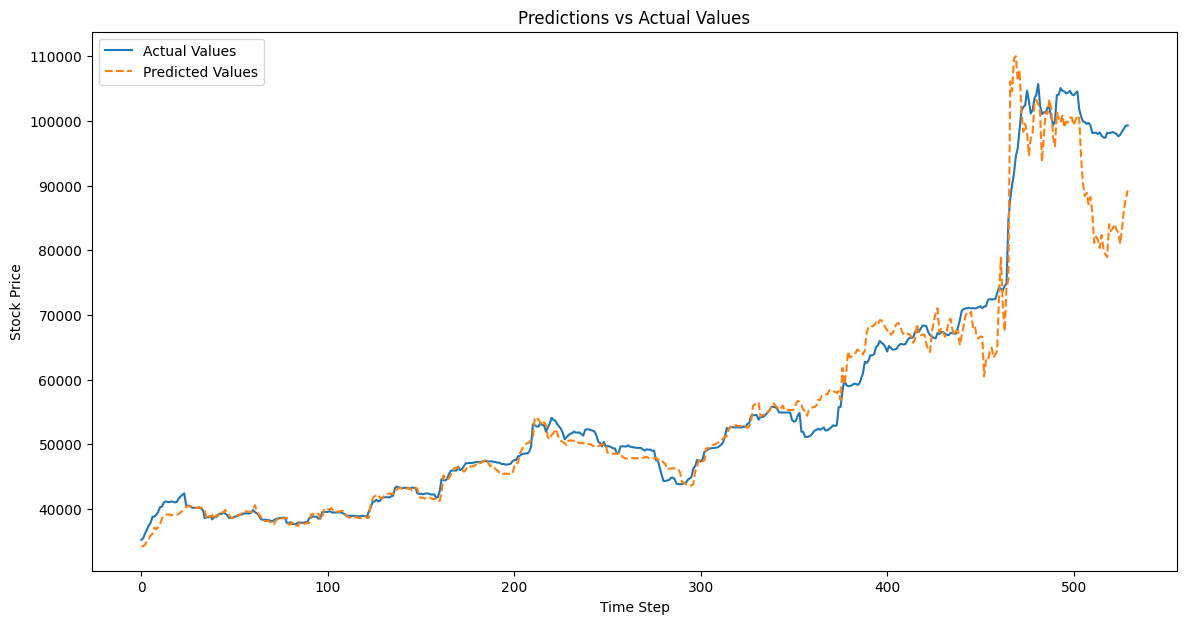

            Metric  Minimum Value  Fold
0    Training Loss       0.000778     1
1  Validation Loss       0.000093     5


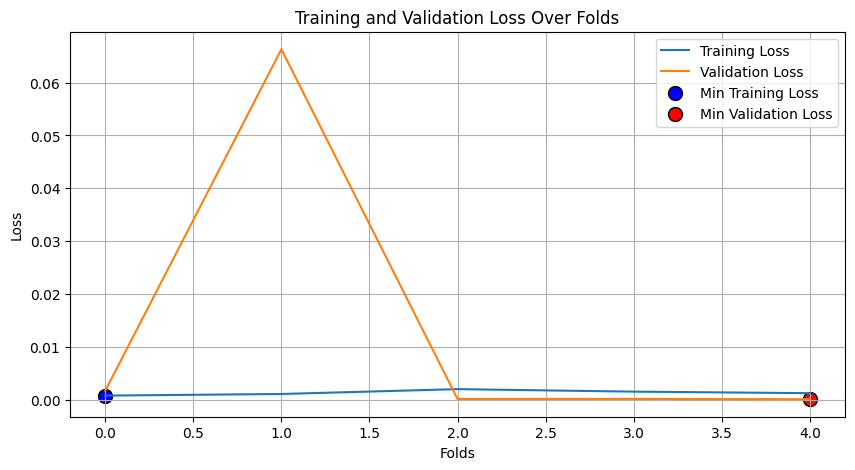

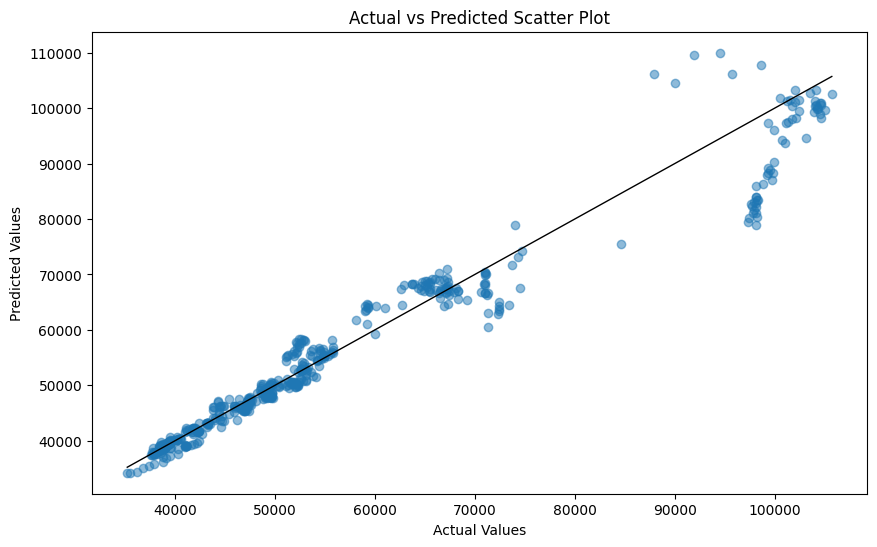

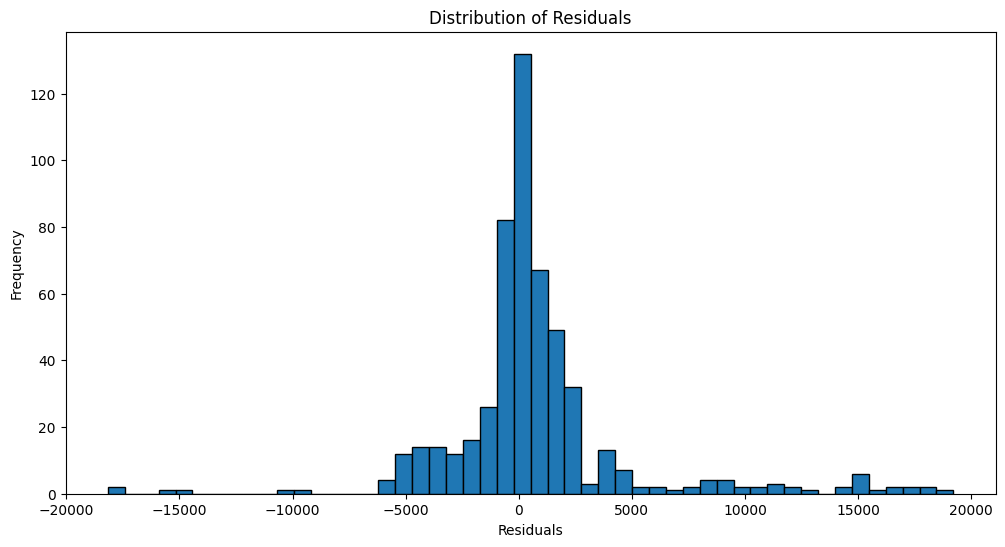

In [ ]:
# Plot predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(Y_test_rescaled, label='Actual Values')
plt.plot(Y_pred_rescaled, label='Predicted Values', linestyle='--')
plt.title('Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Assuming you stored the training and validation losses in lists:
train_losses = final_train_losses
val_losses = final_val_losses

# Find minimum loss values and their indices (fold numbers)
min_train_loss = min(train_losses)
min_val_loss = min(val_losses)
min_train_loss_index = train_losses.index(min_train_loss) + 1  # Adding 1 to convert from index to fold number
min_val_loss_index = val_losses.index(min_val_loss) + 1

# Result Summary
results_summary = pd.DataFrame({
    "Metric": ["Training Loss", "Validation Loss"],
    "Minimum Value": [min_train_loss, min_val_loss],
    "Fold": [min_train_loss_index, min_val_loss_index]
})

print(results_summary)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.scatter(min_train_loss_index - 1, min_train_loss, color='blue', s=100, edgecolors='black', label='Min Training Loss')
plt.scatter(min_val_loss_index - 1, min_val_loss, color='red', s=100, edgecolors='black', label='Min Validation Loss')
plt.title('Training and Validation Loss Over Folds')
plt.xlabel('Folds')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_rescaled, Y_pred_rescaled, alpha=0.5)
plt.plot([Y_test_rescaled.min(), Y_test_rescaled.max()], [Y_test_rescaled.min(), Y_test_rescaled.max()], 'k', lw=1)
plt.title('Actual vs Predicted Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Calculate residuals
residuals = Y_test_rescaled.flatten() - Y_pred_rescaled.flatten()

# Plot distribution of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='k')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
